<center>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-RP0321EN-SkillsNetwork/labs/module_1/images/SN_web_lightmode.png" width="300"> 
</center>


<h1>Predict Hourly Rented Bike Count using Basic Linear Regression Models</h1>

Estimated time needed: **90** minutes


## Lab Overview:

Now that you have performed exploratory analysis on the bike sharing demand dataset and obtained some insights on the attributes, it's time to build predictive models to predict the hourly rented bike count using related weather and date information.

In this lab, you will be asked to use `tidymodels` to build some baseline linear regression models:
- **TASK: Split data into training and testing datasets**
- **TASK: Build a linear regression model using only the weather variables**
- **TASK: Build a linear regression model using both weather and date variables**
- **TASK: Evaluate the models and identify important variables**

Let's start!


First install and import the necessary libraries


In [1]:
# It may take several minutes to install those libraries in Watson Studio
install.packages("rlang")
install.packages("tidymodels")

package 'rlang' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'rlang'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\ProgramData\Anaconda3\Lib\R\library\00LOCK\rlang\libs\x64\rlang.dll to C:\ProgramData\Anaconda3\Lib\R\library\rlang\libs\x64\rlang.dll: Permission denied"
Warning message:
"restored 'rlang'"



The downloaded binary packages are in
	C:\Users\schlarma\AppData\Local\Temp\Rtmpk1f6lS\downloaded_packages
package 'tidymodels' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\schlarma\AppData\Local\Temp\Rtmpk1f6lS\downloaded_packages


In [2]:
library("tidymodels")
library("tidyverse")
library("stringr")

-- Attaching packages -------------------------------------- tidymodels 1.0.0 --

v broom        1.0.4     v recipes      1.0.5
v dials        1.1.0     v rsample      1.1.1
v dplyr        1.1.0     v tibble       3.1.8
v ggplot2      3.4.1     v tidyr        1.3.0
v infer        1.0.4     v tune         1.0.1
v modeldata    1.1.0     v workflows    1.1.3
v parsnip      1.0.4     v workflowsets 1.0.0
v purrr        1.0.1     v yardstick    1.1.0

-- Conflicts ----------------------------------------- tidymodels_conflicts() --
x purrr::discard() masks scales::discard()
x dplyr::filter()  masks stats::filter()
x dplyr::lag()     masks stats::lag()
x recipes::step()  masks stats::step()
* Use tidymodels_prefer() to resolve common conflicts.

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v forcats   1.0.0     v readr     2.1.4
v lubridate 1.9.2     v stringr   1.5.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x readr::

The `seoul_bike_sharing_converted_normalized.csv` will be our main dataset which has following variables:

The response variable:
- `RENTED BIKE COUNT`- Count of bikes rented at each hour

Weather predictor variables:
- `TEMPERATURE` - Temperature in Celsius
- `HUMIDITY` - Unit is `%`
- `WIND_SPEED` - Unit is `m/s`
- `VISIBILITY` - Multiplied by 10m
- `DEW_POINT_TEMPERATURE` - The temperature to which the air would have to cool down in order to reach saturation, unit is Celsius
- `SOLAR_RADIATION` - MJ/m2
- `RAINFALL` - mm
- `SNOWFALL` - cm

Date/time predictor variables:
- `DATE` - Year-month-day
- `HOUR`- Hour of he day
- `FUNCTIONAL DAY` - NoFunc(Non Functional Hours), Fun(Functional hours)
- `HOLIDAY` - Holiday/No holiday
- `SEASONS` - Winter, Spring, Summer, Autumn


Let's read the dataset as a dataframe first:


In [3]:
# Dataset URL
dataset_url <- "seoul_bike_sharing_converted_normalized.csv"
bike_sharing_df <- read_csv(dataset_url, show_col_types = FALSE)
spec(bike_sharing_df)

cols(
  DATE = col_character(),
  RENTED_BIKE_COUNT = col_double(),
  TEMPERATURE = col_double(),
  HUMIDITY = col_double(),
  WIND_SPEED = col_double(),
  VISIBILITY = col_double(),
  DEW_POINT_TEMPERATURE = col_double(),
  SOLAR_RADIATION = col_double(),
  RAINFALL = col_double(),
  SNOWFALL = col_double(),
  FUNCTIONING_DAY = col_character(),
  `0` = col_double(),
  `1` = col_double(),
  `10` = col_double(),
  `11` = col_double(),
  `12` = col_double(),
  `13` = col_double(),
  `14` = col_double(),
  `15` = col_double(),
  `16` = col_double(),
  `17` = col_double(),
  `18` = col_double(),
  `19` = col_double(),
  `2` = col_double(),
  `20` = col_double(),
  `21` = col_double(),
  `22` = col_double(),
  `23` = col_double(),
  `3` = col_double(),
  `4` = col_double(),
  `5` = col_double(),
  `6` = col_double(),
  `7` = col_double(),
  `8` = col_double(),
  `9` = col_double(),
  AUTUMN = col_double(),
  SPRING = col_double(),
  SUMMER = col_double(),
  WINTER = col_double(),
  HOLIDAY 

We won't be using the `DATE` column, because 'as is', it basically acts like an data entry index. (However, given more time, we could use the `DATE` colum to create a 'day of week' or 'isWeekend' column, which we might expect has an affect on preferred bike rental times.) We also do not need the `FUNCTIONAL DAY` column because it only has one distinct value remaining (`YES`) after missing value processing.


In [4]:
bike_sharing_df <- bike_sharing_df %>% 
                   select(-DATE, - FUNCTIONING_DAY)

In [5]:
head(bike_sharing_df)

RENTED_BIKE_COUNT,TEMPERATURE,HUMIDITY,WIND_SPEED,VISIBILITY,DEW_POINT_TEMPERATURE,SOLAR_RADIATION,RAINFALL,SNOWFALL,0,...,6,7,8,9,AUTUMN,SPRING,SUMMER,WINTER,HOLIDAY,NO_HOLIDAY
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
254,0.2202797,0.3775510,0.2972973,1,0.2249135,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
204,0.2150350,0.3877551,0.1081081,1,0.2249135,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
173,0.2062937,0.3979592,0.1351351,1,0.2231834,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
107,0.2027972,0.4081633,0.1216216,1,0.2249135,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
78,0.2062937,0.3673469,0.3108108,1,0.2076125,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
100,0.1993007,0.3775510,0.2027027,1,0.2058824,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


# TASK: Split training and testing data


First, we need to split the full dataset into training and testing datasets.

The training dataset will be used for fitting regression models, and the testing dataset will be used to evaluate the trained models.


_TODO:_ Use the `initial_split()`, `training()`, and `testing()` functions to generate a training dataset consisting of 75% of the original dataset, and a testing dataset using the remaining 25%. 


In [6]:
# Use the `initial_split()`, `training()`, and `testing()` functions to split the dataset
# With seed 1234
set.seed(1234)

# prop = 3/4
bike_split <- initial_split(bike_sharing_df, prop = 0.75)

# Create the training dataset
bike_train <- training(bike_split)

# Create the testing dataset
bike_test <- testing(bike_split)

# TASK: Build a linear regression model using weather variables only


As you could imagine, weather conditions may affect people's bike renting decisions. For example, on a cold and rainy day, you may choose alternate transportation such as a bus or taxi.  While on a nice sunny day, you may want to rent a bike for a short-distance travel.


Thus, can we predict a city's bike-sharing demand based on its local weather information? Let's try to build a regression model to do that.


_TODO:_ Build a linear regression model called `lm_model_weather` using the following variables:

- `TEMPERATURE` - Temperature in Celsius
- `HUMIDITY` - Unit is `%`
- `WIND_SPEED` - Unit is `m/s`
- `VISIBILITY` - Multiplied by 10m
- `DEW_POINT_TEMPERATURE` - The temperature to which the air would have to cool down in order to reach saturation, unit is Celsius
- `SOLAR_RADIATION` - MJ/m2
- `RAINFALL` - mm
- `SNOWFALL` - cm


Define a linear regression model specification.


Fit a model with the response variable `RENTED_BIKE_COUNT` and predictor variables `TEMPERATURE + HUMIDITY + WIND_SPEED + VISIBILITY + DEW_POINT_TEMPERATURE + SOLAR_RADIATION + RAINFALL + SNOWFALL`


In [17]:
# Define the formula
formula <- RENTED_BIKE_COUNT ~ TEMPERATURE + HUMIDITY + WIND_SPEED + VISIBILITY + DEW_POINT_TEMPERATURE + SOLAR_RADIATION + RAINFALL + SNOWFALL

# Fit the linear regression model
lm_model_weather <- lm(formula, data = bike_train)

Print the fit summary for the `lm_model_weather` model.


In [18]:
summary(lm_model_weather$fit)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-1011.2   404.4   734.8   734.9  1055.6  1893.4 

You should see the model details such as formula, residuals, and coefficients.


# TASK: Build a linear regression model using all variables


In addition to weather, there could be other factors that may affect bike rental demand, such as the time of a day or if today is a holiday or not.


Next, let's build a linear regression model using all variables (weather + date/time) in this task.


_TODO:_ Build a linear regression model called `lm_model_all` using all variables `RENTED_BIKE_COUNT ~ .`


In [19]:
# Define the formula
formula <- RENTED_BIKE_COUNT ~ .

# Fit the linear regression model
lm_model_all <- lm(formula, data = bike_train)

Print the fit summary for `lm_model_all`.


In [20]:
summary(lm_model_all$fit)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-1629.7   343.3   735.9   734.9  1127.7  2246.6 

Now you have built two basic linear regression models with different predictor variables, let's evaluate which model has better performance,


# TASK: Model evaluation and identification of important variables


Now that you have built two regression models, `lm_model_weather` and `lm_model_all`, with different predictor variables, you need to compare their performance to see which one is better.


In this project, you will be asked to use very important metrics that are often used in Statistics to determine the performance of a model:

1.  R^2 / R-squared 
2.  Root Mean Squared Error (RMSE)

**R-squared**

<p>R squared, also known as the coefficient of determination, is a measure to indicate how close the data is to the fitted regression line. The value of R-squared is the percentage of variation of the response variable (y) that is explained by a linear model.</p>

**Root Mean Squared Error (RMSE)**
$$
RMSE = \sqrt{MSE}
$$

As you know, the Mean Squared Error measures the average of the squares of errors, where 'error' is the difference between the actual value ($y$) and the estimated value ($ŷ$). 
Another metric that is related to MSE is **Root Mean Squared Error (RMSE)** and is simply the square root of MSE.


We first need to test the `lm_model_weather` and `lm_model_all` models against the test dataset `test_data`, and generate `RENTED_BIKE_COUNT` prediction results.


_TODO:_ Make predictions on the testing dataset using both `lm_model_weather` and `lm_model_all` models


In [21]:
# Use predict() function to generate test results for `lm_model_weather` and `lm_model_all`
# and generate two test results dataframe with a truth column:

# Make predictions using lm_model_weather
bike_test$predicted_rentals_weather <- predict(lm_model_weather, newdata = bike_test)

# Make predictions using lm_model_all
bike_test$predicted_rentals_all <- predict(lm_model_all, newdata = bike_test)

# test_results_weather for lm_model_weather model
print("predicted_rentals_weather")
summary(bike_test$predicted_rentals_weather)
# test_results_all for lm_model_all
print("predicted_rentals_all")
summary(bike_test$predicted_rentals_all)

Warning message in predict.lm(lm_model_all, newdata = bike_test):
"prediction from a rank-deficient fit may be misleading"


[1] "predicted_rentals_weather"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -327.0   394.0   699.0   722.5  1047.0  1782.5 

[1] "predicted_rentals_all"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -598.8   318.4   698.9   710.0  1088.6  2197.3 

NOTE: if you happen to see a warning like : `prediction from a rank-deficient fit may be misleading`, it may be casued by collinearity in the predictor variables. Collinearity means that one predictor variable can be predicted from other predictor variables to some degree. For example, `RAINFALL` could be predicted by `HUMIDITY`.

But dont worry, you will address `glmnet` models (Lasso and Elastic-Net Regularized Generalized Linear Models) instead of regular `regression` models to solve this issue and futher improve the model performance.


Next, let's calculate and print the R-squared and RMSE for the two test results


_TODO:_ Use `rsq()` and `rmse()` functions to calculate R-squared and RMSE metrics for the two test results


In [34]:
print("RSQ")

# Calculate R-squared for lm_model_weather
summary(lm_model_weather)$r.squared

# Calculate R-squared for lm_model_all
summary(lm_model_all)$r.squared

[1] "RSQ"


[1] 0.4302915

[1] 0.6589113

In [33]:
rmse <- function(actual, predicted) {
  sqrt(mean((actual - predicted)^2))
}

print("RMSE")

# Calculate RMSE for lm_model_weather
rmse(bike_test$RENTED_BIKE_COUNT, bike_test$predicted_rentals_weather)

# Calculate RMSE for lm_model_all
rmse(bike_test$RENTED_BIKE_COUNT, bike_test$predicted_rentals_all)

[1] "RMSE"


[1] 474.6247

[1] 364.4235

From these tables, you should find that the test results from `lm_model_all` are much better. It means that using both weather and datetime variables in the model generates better prediction results.


Since `lm_model_all` has many predictor variables, let's check which predictor variables have larger coefficients. Variables with larger coefficients in the model means they attribute more in the prediction of `RENTED_BIKE_COUNT`. In addition, since all predictor variables are normalized to the same scale, 0 to 1, we thus can compare their coefficients directly.


You could try building another regression model using the non-normalized `seoul_bike_sharing_converted.csv` dataset, and you would find that the coefficients are much different.


First let's print all coefficients:


In [39]:
# Get the coefficient list from lm_model_all
coef_list <- lm_model_all$coefficients

hmm, it's not very clear to compare the coefficients from a long and unsorted list. Next, you need to sort and visualize them using a bar chart


_TODO:_ Sort the coefficient list in descending order and visualize the result using `ggplot` and `geom_bar` 


In [56]:
# Create a data frame with the coefficients and variable names
coef_df <- data.frame(variable = names(lm_model_all$coefficients), 
                      coef = lm_model_all$coefficients)

# Sort the data frame by coefficient values
coef_df <- coef_df[order(coef_df$coef, decreasing = TRUE),]

Warning message:
"Removed 3 rows containing missing values (`position_stack()`)."


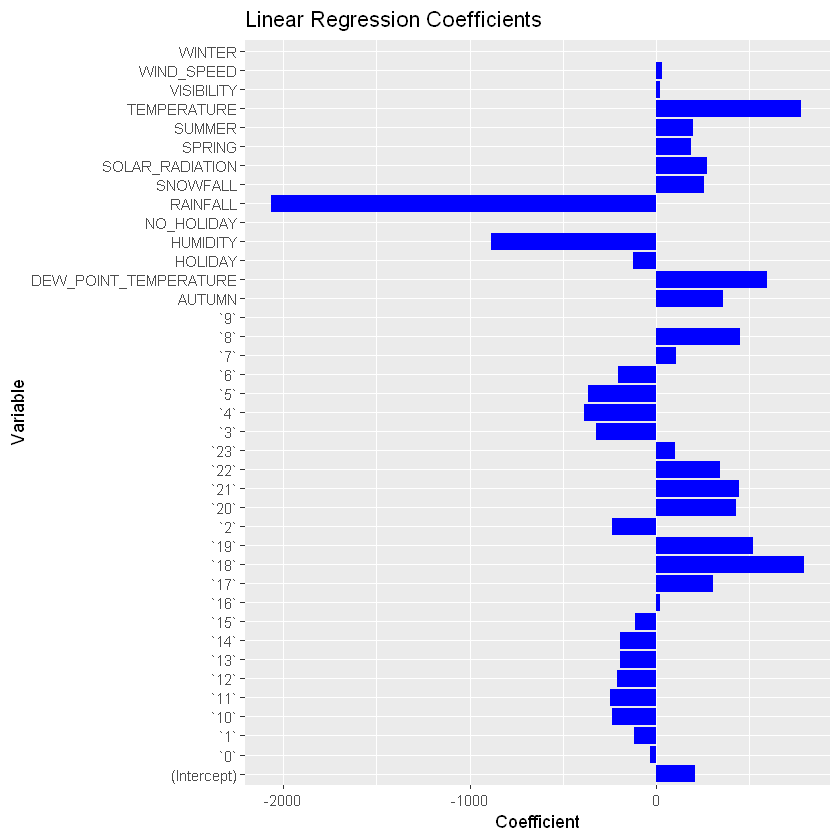

In [58]:
# Create the bar plot
ggplot(data = coef_df, aes(x = variable, y = coef)) + 
  geom_bar(stat = "identity", fill = "blue") +
  coord_flip() +
  ggtitle("Linear Regression Coefficients") +
  xlab("Variable") + ylab("Coefficient")

You should see a sorted coefficient bar chart like the following example: 


<a href="https://cognitiveclass.ai/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkRP0321ENSkillsNetwork878-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-RP0321EN-SkillsNetwork/labs/module_4/images/coefficient_chart.png" width="600" align="center">
</a>


Mark down these 'top-ranked variables by coefficient', which will be used for model refinments in the next labs.


Note that here the main reason we use absolute value is to easily identify important variables, i.e. variables with large magnitudes, no matter it's negative or positive. If we want to interprete the model then it's better to seperate the positive and negative coefficients.


# Next Steps


Great! Now you have built a baseline linear regression model to predict hourly bike rent count, with reasonably good performance. In the next lab, you will be refining the baseline model to improve its performance.


## Authors

<a href="https://www.linkedin.com/in/yan-luo-96288783/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkRP0321ENSkillsNetwork878-2022-01-01" target="_blank">Yan Luo</a>


### Other Contributors

Jeff Grossman


## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description           |
| ----------------- | ------- | ---------- | ---------------------------- |
| 2021-04-08        | 1.0     | Yan        | Initial version created      |
|                   |         |            |                              |
|                   |         |            |                              |

## <h3 align="center"> © IBM Corporation 2021. All rights reserved. <h3/>
